<a href="https://colab.research.google.com/github/cybercat17/MLDL/blob/master/Titanic_intermediate_manipulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Downloading datasets from Kaggle

In [0]:
from google.colab import files
files.upload()

{}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c titanic

train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


## Preprocessing Data

In [0]:
import pandas as pd

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [135]:
unrelated_cols = ['Ticket', 'Cabin']

train_df.drop(unrelated_cols, axis=1, inplace=True)
test_df.drop(unrelated_cols, axis=1, inplace=True)
print('Train : {} / Test : {}'.format(train_df.shape, test_df.shape))

Train : (891, 10) / Test : (418, 9)


In [136]:
combine = [train_df, test_df]

for dataset in combine:
  dataset['Title'] = dataset.Name.str.extract('([A-Za-z]+)\.', expand=False)
 
pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


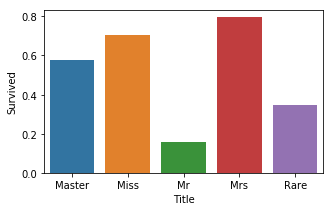

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns

for dataset in combine:
  dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
  dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
  dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
  dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

plt.figure(figsize=(5, 3))
by_title = train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()
sns.barplot(x=by_title.Title, y=by_title.Survived)

In [138]:
title_mapping = {'Mr':1, 'Miss':2, 'Mrs':3, 'Master':4, 'Rare':5}

for dataset in combine:
  dataset['Title'] = dataset['Title'].map(title_mapping)
  dataset['Title'].fillna(0, inplace=True)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


In [0]:
train_df.drop(['Name', 'PassengerId'], axis=1, inplace=True)
test_df.drop(['Name'], axis=1, inplace=True)
combine = [train_df, test_df]

In [140]:
for dataset in combine:
  dataset['Sex'] = dataset['Sex'].map({'female':1, 'male':0}).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1


In [141]:
import numpy as np

guess_ages = np.zeros((2, 3))
guess_ages

array([[0., 0., 0.],
       [0., 0., 0.]])

In [142]:
for dataset in combine:
  for i in range(2):
    for j in range(1, 4):
      guess_df = dataset[(dataset['Sex']==i) & (dataset['Pclass']==j)]['Age'].dropna(axis=0)
      med_age = guess_df.median()
      guess_ages[i, j-1] = int(med_age/0.5+0.5)*0.5
  for i in range(2):
    for j in range(1, 4):
      dataset.loc[(dataset.Age.isnull()) & (dataset.Sex==i) & (dataset.Pclass==j), 'Age'] = guess_ages[i, j-1]
  dataset['Age'] = dataset['Age'].astype(int)
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1
1,1,1,1,38,1,0,71.2833,C,3
2,1,3,1,26,0,0,7.9250,S,2
3,1,1,1,35,1,0,53.1000,S,3
4,0,3,0,35,0,0,8.0500,S,1


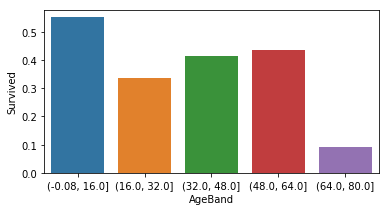

In [143]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
by_ageband = train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand')
plt.figure(figsize=(6, 3))
sns.barplot(x=by_ageband.AgeBand, y=by_ageband.Survived)

In [144]:
for dataset in combine:
  dataset.loc[dataset['Age']<=16, 'Age']=0
  dataset.loc[(dataset['Age']>16) & (dataset['Age']<=32), 'Age']=1
  dataset.loc[(dataset['Age']>32) & (dataset['Age']<=48), 'Age']=2
  dataset.loc[(dataset['Age']>48) & (dataset['Age']<=60), 'Age']=3
  dataset.loc[(dataset['Age']>60), 'Age']=4
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,0,3,0,1,1,0,7.2500,S,1,"(16.0, 32.0]"
1,1,1,1,2,1,0,71.2833,C,3,"(32.0, 48.0]"
2,1,3,1,1,0,0,7.9250,S,2,"(16.0, 32.0]"
3,1,1,1,2,1,0,53.1000,S,3,"(32.0, 48.0]"
4,0,3,0,2,0,0,8.0500,S,1,"(32.0, 48.0]"


In [0]:
train_df.drop(['AgeBand'], axis=1, inplace=True)
combine = [train_df, test_df]

In [146]:
for dataset in combine:
  dataset['FamilySize'] = dataset['Parch'] + dataset['SibSp'] + 1

train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [147]:
for dataset in combine:
  dataset['IsAlone'] = 0
  dataset.loc[dataset['FamilySize']==1, 'IsAlone'] = 1
  
train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [148]:
drop_cols = ['Parch', 'SibSp', 'FamilySize']
train_df.drop(drop_cols, axis=1, inplace=True)
test_df.drop(drop_cols, axis=1, inplace=True)
combine = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,7.2500,S,1,0
1,1,1,1,2,71.2833,C,3,0
2,1,3,1,1,7.9250,S,2,1
3,1,1,1,2,53.1000,S,3,0
4,0,3,0,2,8.0500,S,1,1


In [149]:
for dataset in combine:
  dataset['Pclass*Age'] = dataset['Pclass']*dataset['Age']
train_df.loc[:,['Age', 'Pclass', 'Pclass*Age']].head()

,Age,Pclass,Pclass*Age
0,1,3,3
1,2,1,2
2,1,3,3
3,2,1,2
4,2,3,6


In [150]:
freq_port = train_df.Embarked.dropna().mode()[0]
freq_port

'S'

In [151]:
for dataset in combine:
  dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived')

,Embarked,Survived
2,S,0.339009
1,Q,0.389610
0,C,0.553571


In [152]:
for dataset in combine:
  dataset['Embarked'] = dataset['Embarked'].map({'S':0, 'Q':1, 'C':2}).astype(int)
train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Pclass*Age
0,0,3,0,1,7.2500,0,1,0,3
1,1,1,1,2,71.2833,2,3,0,2
2,1,3,1,1,7.9250,0,2,1,3
3,1,1,1,2,53.1000,0,3,0,2
4,0,3,0,2,8.0500,0,1,1,6


In [153]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Pclass*Age
0,892,3,0,2,7.8292,1,1,1,6
1,893,3,1,2,7.0000,0,3,0,6
2,894,2,0,4,9.6875,1,1,1,8
3,895,3,0,1,8.6625,0,1,1,3
4,896,3,1,1,12.2875,0,3,0,3


In [154]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand')

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [155]:
for dataset in combine:
  dataset.loc[dataset['Fare']<=7.91, 'Fare']=0
  dataset.loc[(dataset['Fare']>7.91) & (dataset['Fare']<=14.454), 'Fare']=1
  dataset.loc[(dataset['Fare']>14.454) & (dataset['Fare']<=31.0), 'Fare']=2
  dataset.loc[(dataset['Fare']>31.0), 'Fare']=3
  dataset['Fare'] = dataset['Fare'].astype(int)
  
train_df.drop(['FareBand'], axis=1, inplace=True)
combine = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Pclass*Age
0,0,3,0,1,0,0,1,0,3
1,1,1,1,2,3,2,3,0,2
2,1,3,1,1,1,0,2,1,3
3,1,1,1,2,3,0,3,0,2
4,0,3,0,2,1,0,1,1,6


In [156]:
test_df.shape, train_df.shape

((418, 9), (891, 9))

## Training the Model

In [159]:
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Survived      891 non-null int64
Pclass        891 non-null int64
Sex           891 non-null int64
Age           891 non-null int64
Fare          891 non-null int64
Embarked      891 non-null int64
Title         891 non-null int64
IsAlone       891 non-null int64
Pclass*Age    891 non-null int64
dtypes: int64(9)
memory usage: 62.7 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Sex            418 non-null int64
Age            418 non-null int64
Fare           418 non-null int64
Embarked       418 non-null int64
Title          418 non-null int64
IsAlone        418 non-null int64
Pclass*Age     418 non-null int64
dtypes: int64(9)
memory usage: 29.5 KB


In [0]:
y = train_df.Survived
train_df.drop(['Survived'], axis=1, inplace=True)

In [0]:
from xgboost import XGBClassifier

model = XGBClassifier(n_estimators=1000, learning_rate=0.1)
model.fit(train_df, y)

preds = model.predict(test_df.drop(['PassengerId'], axis=1))

In [0]:
output = pd.DataFrame({'PassengerId':test_df.PassengerId, 'Survived':preds})
output.to_csv('submission.csv', index=False)